# Sound Classification Data Exploration

This notebook is intended for initial exploration and analysis of the sound datasets used in the home sound classification project. We will load the datasets, visualize sound data, and perform exploratory data analysis.

FIRST STEP - DATA PRE PROCESSING

In [1]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

INFO: Downloading ['all', 'index']. Index is being stored in C:\Users\ebd-marco\Documents\homeaudio_ml\homeaudio\Lib\site-packages\soundata\datasets\indexes, and the rest of files in /tmp\sound_datasets\urbansound8k
INFO: [all] downloading UrbanSound8K.tar.gz
INFO: /tmp\sound_datasets\urbansound8k\UrbanSound8K.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: /tmp\sound_datasets\urbansound8k\audio already exists. Run with force_overwrite=True to download from scratch
INFO: /tmp\sound_datasets\urbansound8k\FREESOUNDCREDITS.txt already exists. Run with force_overwrite=True to download from scratch
INFO: /tmp\sound_datasets\urbansound8k\metadata already exists. Run with force_overwrite=True to download from scratch
INFO: /tmp\sound_datasets\urbansound8k\UrbanSound8K_README.txt already exists. Run with force_overwrite=True to download from scratch
INFO: [index] downloading urbansound8k_index_1.0.json
INFO: C:

({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

In [2]:
example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

Clip(
  audio_path="/tmp\sound_datasets\urbansound8k\audio/fold9/157866-8-0-0.wav",
  clip_id="157866-8-0-0",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time: Th

In [3]:
import librosa
example_path = example_clip.audio_path
audio, audio_sr = librosa.load(example_path) #audio = numpy array ||| audio_sr = int

In [4]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr = audio_sr) #raw mel spectrogram

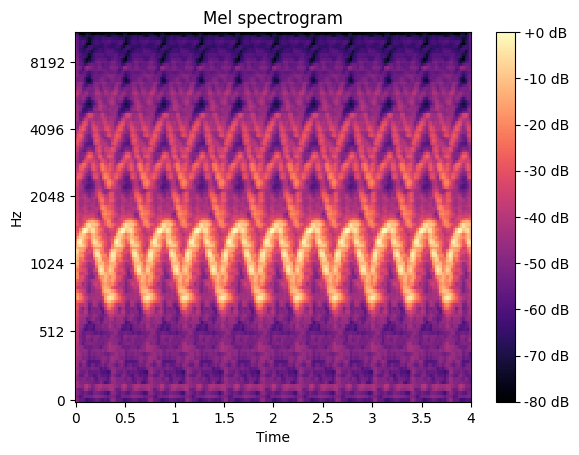

In [5]:
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

#Convert spectrogram to db
mel_spectrogram_db = librosa.power_to_db(S = mel_spectrogram, ref = np.max)

#Plot the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spectrogram_db, x_axis = 'time', y_axis = 'mel', sr = audio_sr, ax = ax)

#Add color bar and title for clarity
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel spectrogram')

#Show the plot
plt.show()

In [6]:
desired_time = 4#s
mel_spectrograms = []
clip_labels = []

for clip_id in dataset.clip_ids:
    clip = dataset.clip(clip_id)
    audio, sampling_rate = librosa.load(clip.audio_path)
    duration = len(audio)/sampling_rate
    
    if duration < desired_time:
        num_points = int(desired_time*sampling_rate) - len(audio)
        formatted_clip = np.pad(audio, (0, num_points), 'constant')
    else:
        desired_length = int(desired_time*sampling_rate)
        formatted_clip = audio[:desired_length]

    mel_spectrograms.append(librosa.feature.melspectrogram(y=formatted_clip, sr = sampling_rate))
    clip_labels.append(clip.class_label)
    

In [13]:
import tensorflow as tf
input_shape = (128, 173, 1)
pool_size = (2,2)

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,
                          kernel_size=(3,3),
                          activation='relu', 
                          input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size = pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
                 ])

In [14]:
cnn_model.compile(optimizer= 'adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
spectrograms_np = np.array(mel_spectrograms)
spectrograms_np = np.expand_dims(spectrograms_np, axis=-1)

class_names = sorted(list(set(clip_labels)))

label_to_id = {name: i for i, name in enumerate(class_names)}

all_labels_id = [label_to_id[label] for label in clip_labels]

labels_np = np.array(all_labels_id)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(f"Shape of training data: {spectrograms_np.shape}")
x_train, x_val, y_train, y_val = train_test_split(spectrograms_np, labels_np, test_size = 0.2, random_state = 42)

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 5,
                          min_delta = 0.01)

history = cnn_model.fit(x_train,
                        y_train,
                        epochs = 100,
                        batch_size = 32,
                        validation_data = (x_val,y_val),
                        verbose=1,
                        callbacks = [early_stop]
                       )

Shape of training data: (8732, 128, 173, 1)
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.7276 - loss: 0.8434 - val_accuracy: 0.5529 - val_loss: 2.7651
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.7238 - loss: 0.8323 - val_accuracy: 0.5266 - val_loss: 3.3234
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.7618 - loss: 0.7375 - val_accuracy: 0.5386 - val_loss: 3.3377
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.7843 - loss: 0.6769 - val_accuracy: 0.5581 - val_loss: 3.5724
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.8074 - loss: 0.6291 - val_accuracy: 0.5570 - val_loss: 3.7840
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.7946 - loss: 0.6814 - val_accuracy: 0.5518 - val_loss: 3.9061


In [24]:
cnn_model.save('sound_classifier_unquantized.h5')

In [20]:
print(help(tf.lite.TFLiteConverter))

Help on class TFLiteConverterV2 in module tensorflow.lite.python.lite:

class TFLiteConverterV2(TFLiteFrozenGraphConverterV2)
 |  TFLiteConverterV2(funcs, trackable_obj=None)
 |
 |  Converts a TensorFlow model into TensorFlow Lite model.
 |
 |  Attributes:
 |    optimizations: Experimental flag, subject to change. Set of optimizations to
 |      apply. e.g {tf.lite.Optimize.DEFAULT}. (default None, must be None or a
 |      set of values of type `tf.lite.Optimize`)
 |    representative_dataset: A generator function used for integer quantization
 |      where each generated sample has the same order, type and shape as the
 |      inputs to the model. Usually, this is a small subset of a few hundred
 |      samples randomly chosen, in no particular order, from the training or
 |      evaluation dataset. This is an optional attribute, but required for full
 |      integer quantization, i.e, if `tf.int8` is the only supported type in
 |      `target_spec.supported_types`. Refer to `tf.lite

In [22]:
def representative_data_gen():
  # Get a small sample of your training data
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

In [23]:
# Step 1: Instantiate the TensorFlow Lite converter
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)

# Step 2: Set the optimization flag to quantize the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Step 3: Set the representative dataset for integer quantization
converter.representative_dataset = representative_data_gen

# Step 4: Convert the model to a quantized TFLite format
tflite_model = converter.convert()

# Step 5: Save the converted model to a .tflite file
with open('sound_classifier_quantized.tflite', 'wb') as f:
  f.write(tflite_model)

INFO: Function `function` contains input name(s) resource with unsupported characters which will be renamed to sequential_1_1_dense_3_1_biasadd_readvariableop_resource in the SavedModel.
INFO: Function `function` contains input name(s) resource with unsupported characters which will be renamed to sequential_1_1_dense_3_1_biasadd_readvariableop_resource in the SavedModel.
INFO: Assets written to: C:\Users\EBD-MA~1\AppData\Local\Temp\tmp3ikna1at\assets


Saved artifact at 'C:\Users\EBD-MA~1\AppData\Local\Temp\tmp3ikna1at'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 173, 1), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1388378855504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388378856272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388378854736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388378855120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388378857040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388378853584: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ebd-marco\Documents\homeaudio_ml\homeaudio\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
